#<font color='blue'><b>0.Installation</b></font>

<font color='blue'><b>**1. Importation des bibliothèques**</b></font>

In [1]:
# @title <font color='black'><b>**Bibliothèques**</b></font> { run: "auto" }
# Import des bibliothèques nécessaires
import matplotlib.pyplot as plt
import pandas as pd
import requests
import zipfile
import io
import os
from wordcloud import WordCloud
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report
import warnings
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.nn.utils import clip_grad_norm_
from torch.nn import Dropout
from tqdm import tqdm
import pandas as pd

In [2]:
# @title <font color='black'><b>**Folder**</b></font> { run: "auto" }
# Ignorer tous les avertissements
warnings.filterwarnings("ignore")
import os
import shutil

# Vérifier si le répertoire existe
if os.path.exists("model"):
    # S'il existe, supprimer complètement le répertoire et son contenu
    shutil.rmtree("model")

# Recréer le répertoire
os.makedirs("model")

<font color='blue'><b>**2. Importation du dataset**</b></font>

In [3]:
# @title <font color='black'><b>**Data**</b></font> { run: "auto", display-mode: "form" }
# URL du fichier ZIP sur GitHub (branche principale)
url_zipfile = "https://github.com/Elzoghost/Detection_FakeNews_IA/raw/main/fake-news.zip"

# Effectuer une requête GET pour télécharger le fichier ZIP
response = requests.get(url_zipfile)

# Vérifier si la requête a réussi (statut HTTP 200)
if response.status_code == 200:
    # Créer un objet ZipFile à partir des données téléchargées
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
        # Extraire le contenu du fichier ZIP (par exemple, ici, nous l'extrayons dans un dossier "data")
        zip_file.extractall("data")

    print("Le fichier ZIP a été téléchargé et extrait avec succès.")
else:
    print("Échec du téléchargement du fichier ZIP.")

Le fichier ZIP a été téléchargé et extrait avec succès.


In [4]:
# @title <font color='black'><b>**Chargement de la data**</b></font> { run: "auto" }
# Étape 1: load_data()
def load_data(train_file, test_file,submit_file):
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    submit_data = pd.read_csv(submit_file)
    return train_data, test_data, submit_data

# Chargement des données
train_data, test_data, submit_data = load_data('/content/data/train.csv', '/content/data/test.csv', '/content/data/submit.csv')
print("Données chargées avec succès.")

Données chargées avec succès.


In [5]:
# @title <font color='black'><b>**Shape**</b></font> { run: "auto" }
train=train_data.shape
print('train_data shape:', train)
print('\n')
test=test_data.shape
print('test_data shape:', test)
print('\n')
sub=submit_data.shape
print('submit sample shape:', sub)

train_data shape: (20800, 5)


test_data shape: (5200, 4)


submit sample shape: (5200, 2)


#<font color='blue'><b>I.Partie Analyse</b></font>

##<font color='blue'><b>**I.1. Histogramme de la distribution des classes :**</b></font>

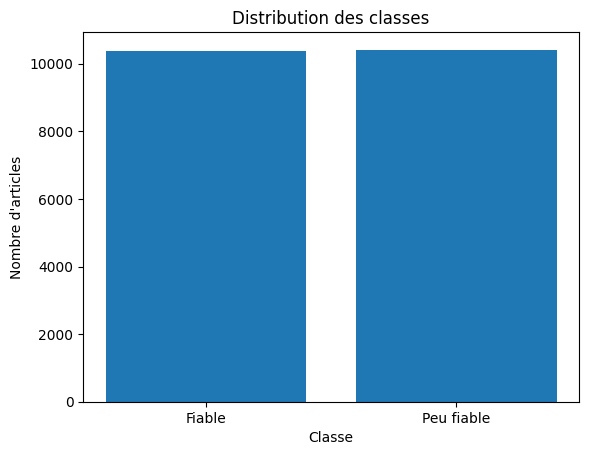

In [6]:
# @title <font color='black'><b>**Distribution des classes**</b></font> { run: "auto" }
# Analyse de la distribution des classes
class_distribution = train_data["label"].value_counts()
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel("Classe")
plt.ylabel("Nombre d'articles")
plt.xticks([0, 1], ["Fiable", "Peu fiable"])
plt.title("Distribution des classes")
plt.show()

##<font color='blue'><b>**I.2. Analyse de la longueur des articles :**</b></font>

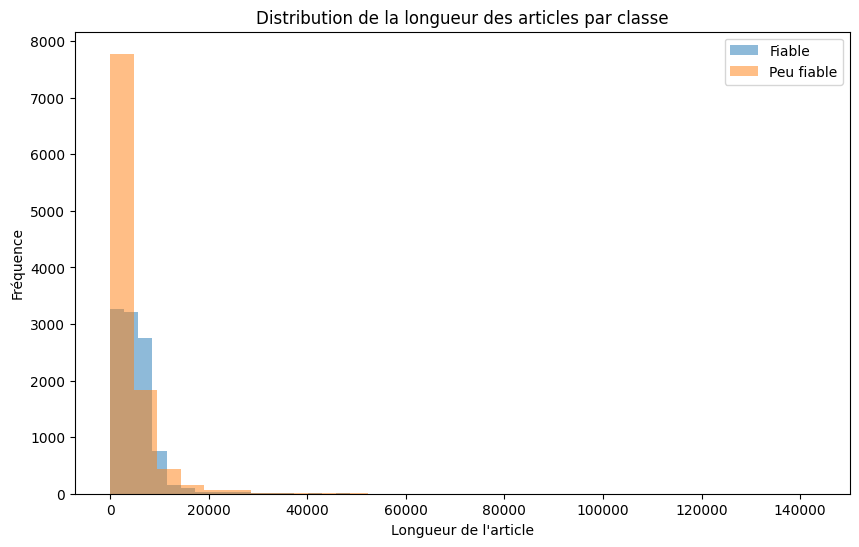

In [7]:
# @title <font color='black'><b>**Longueur des classes**</b></font> { run: "auto" }
# Analyse de la longueur des articles
train_data["article_length"] = train_data["text"].apply(lambda x: len(str(x)))
plt.figure(figsize=(10, 6))
plt.hist(train_data[train_data["label"] == 0]["article_length"], bins=30, alpha=0.5, label="Fiable")
plt.hist(train_data[train_data["label"] == 1]["article_length"], bins=30, alpha=0.5, label="Peu fiable")
plt.xlabel("Longueur de l'article")
plt.ylabel("Fréquence")
plt.legend()
plt.title("Distribution de la longueur des articles par classe")
plt.show()

##<font color='blue'><b>**I.3. Nuage de mots (Word Cloud) :**</b></font>

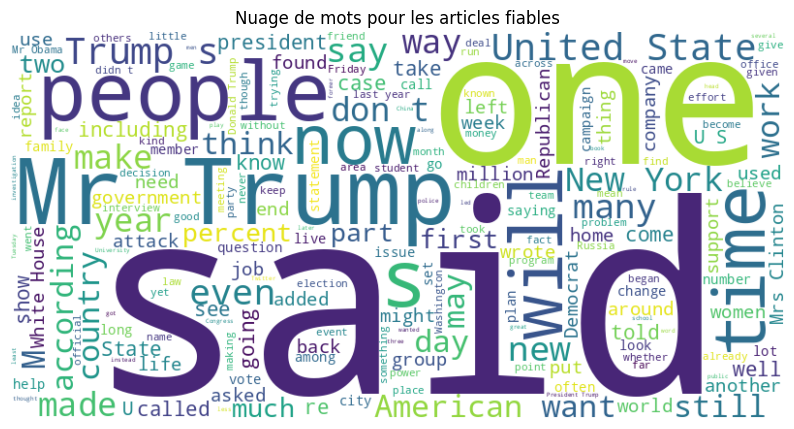

In [8]:
# @title <font color='black'><b>**Nuage de mots fiables**</b></font> { run: "auto" }
# Créer un nuage de mots pour les articles fiables
text_unreliable = " ".join(train_data[train_data["label"] == 0]["text"].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_unreliable)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots pour les articles fiables")
plt.show()

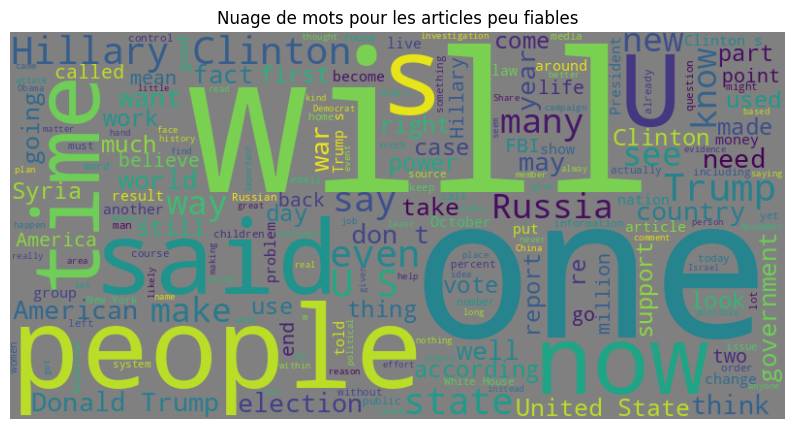

In [9]:
# @title <font color='black'><b>**Nuage de mots peu fiable**</b></font> { run: "auto" }
# Créer un nuage de mots pour les articles peu fiables
text_unreliable = " ".join(train_data[train_data["label"] == 1]["text"].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="grey").generate(text_unreliable)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots pour les articles peu fiables")
plt.show()

#<font color='blue'><b>II.Partie Modele</b></font>

##<font color='blue'><b>II.1 : Prétraitement des données</b></font>

In [10]:
# @title <font color='black'><b>**Prétraitement**</b></font> { run: "auto" }
# Étape 2: preprocess_data()
from sklearn.model_selection import train_test_split

def preprocess_data(train_data, test_size=0.2, batch_size=16):
    # Remplissage des valeurs manquantes dans les données avec des chaînes vides
    train_data = train_data.fillna('')

    # Division des données en ensembles d'entraînement et de validation
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_data['text'], train_data['label'], test_size=test_size, random_state=42
    )

    # Tokenization avec BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=256, return_tensors='pt')
    val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=256, return_tensors='pt')

    # Création des datasets PyTorch
    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_labels.tolist()))
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(val_labels.tolist()))

    # Création des dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader

##<font color='blue'><b>II.2 : Construction du modèle</b></font>

In [11]:
# @title <font color='black'><b>**Initialisation du modéle**</b></font> { run: "auto" }
from transformers import BertForSequenceClassification, BertConfig
from transformers import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

def initialize_model(num_labels=2, dropout_prob=0.5, learning_rate=2e-5):
    # Configuration de BERT
    config = BertConfig.from_pretrained('bert-base-uncased', num_labels=num_labels)

    # Initialisation du modèle
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

    # Modification du dropout
    model.dropout = torch.nn.Dropout(dropout_prob)

    return model

In [12]:
# @title <font color='black'><b>**Unité de traitement**</b></font> { run: "auto" }
def set_device(model):
    device = torch.device("cuda"if torch.cuda.is_available() else "cpu")
    model.to(device)
    return device

##<font color='blue'><b>II.3 : Entraînement et Evaluation du modèle</b></font>

In [13]:
# @title <font color='black'><b>**Optimiseur**</b></font> { run: "auto" }
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

def set_optimizer(model, learning_rate=2e-5, weight_decay=0.1, num_training_steps=1000, num_warmup_steps=100):
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Scheduler avec warmup
    #scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

    return optimizer #, scheduler

In [14]:
# @title <font color='black'><b>**Programme**</b></font> { run: "auto" }
from transformers import get_linear_schedule_with_warmup

def set_scheduler(optimizer, train_dataloader, epochs, num_warmup_steps=None):
    if num_warmup_steps is None:
        num_warmup_steps = int(0.2 * len(train_dataloader) * epochs)  # Utilisez 20% du nombre total d'étapes comme nombre d'étapes de warmup

    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)
    return scheduler

In [15]:
# @title <font color='black'><b>**Train**</b></font> { run: "auto" }
from torch.nn.utils import clip_grad_norm_
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, device, epochs=3):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_accuracy = 0.0

    for epoch in range(epochs):
        # Entraînement du modèle
        model.train()
        epoch_train_losses = []
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/Training"):
            optimizer.zero_grad()
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip gradients
            optimizer.step()
            scheduler.step()  # Scheduler step moved here for more fine-grained control

            # Ajout de la loss à la liste des losses de l'époque
            epoch_train_losses.append(loss.item())

        # Validation du modèle
        model.eval()
        epoch_val_losses = []
        epoch_val_accuracies = []
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/Validation"):
                input_ids, attention_mask, labels = batch
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1)
                accuracy = torch.sum(predictions == labels).item() / len(labels)

                # Ajout de la loss et de la précision à la liste des métriques de l'époque
                epoch_val_losses.append(loss.item())
                epoch_val_accuracies.append(accuracy)

        # Calcul des moyennes des losses et des précisions de l'époque
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        avg_val_accuracy = sum(epoch_val_accuracies) / len(epoch_val_accuracies)

        # Enregistrement des métriques dans les listes correspondantes
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        # Mise à jour du meilleur score de validation et sauvegarde du modèle si nécessaire
        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            torch.save(model.state_dict(), '/content/model/best_model_weights.pth')

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")

    print("Training completed.")

    # Création du DataFrame pandas contenant les résultats de l'entraînement
    results_df = pd.DataFrame({
        'Epoch': range(1, epochs + 1),
        'Train Loss': train_losses,
        'Validation Loss': val_losses,
        'Validation Accuracy': val_accuracies
    })

    return results_df

In [16]:
# @title <font color='black'><b>**Train et Eval**</b></font> { run: "auto" }
# Initialisation du modèle
model = initialize_model()

# Charger les données d'entraînement et de validation
train_dataloader, val_dataloader = preprocess_data(train_data)

# Définir l'optimiseur et le scheduler
optimizer = set_optimizer(model)
scheduler = set_scheduler(optimizer, train_dataloader, epochs=3)

# Définir le dispositif
device = set_device(model)

# Entraîner le modèle et récupérer les résultats
results_df = train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, device, epochs=3)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Epoch 1/Validation: 100%|██████████| 260/260 [01:02<00:00,  4.13it/s]


Epoch 1/3 - Train Loss: 0.2199, Validation Loss: 0.0444, Validation Accuracy: 0.9906


Epoch 2/Validation: 100%|██████████| 260/260 [01:02<00:00,  4.14it/s]


Epoch 2/3 - Train Loss: 0.0208, Validation Loss: 0.0231, Validation Accuracy: 0.9950


Epoch 3/Validation: 100%|██████████| 260/260 [01:02<00:00,  4.13it/s]

Epoch 3/3 - Train Loss: 0.0032, Validation Loss: 0.0259, Validation Accuracy: 0.9950
Training completed.


In [17]:
# @title <font color='black'><b>**Rapport de Classiffication**</b></font> { run: "auto" }
from tabulate import tabulate
import numpy as np

# Fonction pour générer un rapport sous forme de tableau avec des couleurs
def generate_report(results_df):
    # Créer le tableau avec les en-têtes
    table = [["Epoch", "Train Loss", "Validation Loss", "Validation Accuracy"]]

    # Remplir le tableau avec les valeurs et les couleurs correspondantes
    for epoch, train_loss, val_loss, val_acc in results_df.itertuples(index=False):
        # Ajouter la ligne au tableau
        table.append([epoch, f"{train_loss:.4f}", f"{val_loss:.4f}", f"{val_acc:.4f}"])

    # Générer le rapport sous forme de tableau avec des couleurs
    headers = table.pop(0)
    table = np.array(table)
    avg_val_acc = table[:, -1].astype(float).mean()
    highlighted_rows = [
        (epoch, train_loss, val_loss, val_acc)
        for epoch, train_loss, val_loss, val_acc in zip(results_df['Epoch'], results_df['Train Loss'], results_df['Validation Loss'], results_df['Validation Accuracy'])
        if float(val_acc) >= avg_val_acc
    ]
    report_table = tabulate(table, headers=headers, tablefmt="fancy_grid", floatfmt=".4f")

    # Ajouter un titre au rapport
    title = "Rapport d'entrainement et de validation"
    report = f"{title}\n{report_table}"

    return report

# Appeler la fonction pour générer le rapport à partir du DataFrame contenant les résultats
report = generate_report(results_df)
print(report)

Rapport d'entrainement et de validation
╒═════════╤══════════════╤═══════════════════╤═══════════════════════╕
│   Epoch │   Train Loss │   Validation Loss │   Validation Accuracy │
╞═════════╪══════════════╪═══════════════════╪═══════════════════════╡
│       1 │       0.2199 │            0.0444 │                0.9906 │
├─────────┼──────────────┼───────────────────┼───────────────────────┤
│       2 │       0.0208 │            0.0231 │                0.9950 │
├─────────┼──────────────┼───────────────────┼───────────────────────┤
│       3 │       0.0032 │            0.0259 │                0.9950 │
╘═════════╧══════════════╧═══════════════════╧═══════════════════════╛


##<font color='blue'><b>II.4 : Graphe d'évaluation du modèle</b></font>

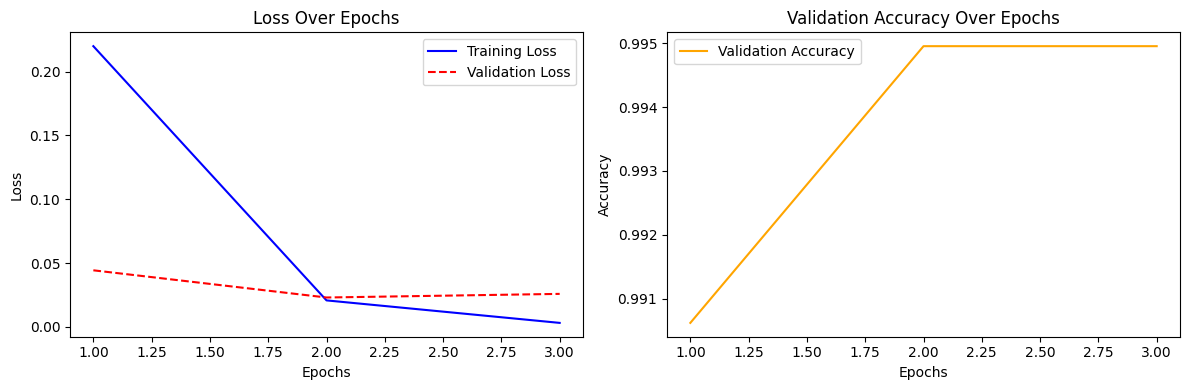

In [18]:
# @title <font color='black'><b>**Graphe d'entrainement et de validation**</b></font> { run: "auto" }
import matplotlib.pyplot as plt

def plot_training_results(results_df):
    epochs = len(results_df)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Courbes de perte
    axs[0].plot(results_df['Epoch'], results_df['Train Loss'], label='Training Loss', color='blue', linestyle='-')
    axs[0].plot(results_df['Epoch'], results_df['Validation Loss'], label='Validation Loss', color='red', linestyle='--')
    axs[0].set_title('Loss Over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Courbe d'exactitude
    axs[1].plot(results_df['Epoch'], results_df['Validation Accuracy'], label='Validation Accuracy', color='orange')
    axs[1].set_title('Validation Accuracy Over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Utilisation des fonctions pour créer les graphes
plot_training_results(results_df)

#<font color='blue'><b>III.Partie Test</b></font>

##<font color='blue'><b>III.1: Préparation du modéle pour le test :</b></font>

In [19]:
# @title <font color='black'><b>**Traitement**</b></font> { run: "auto" }
def preprocess_test_data(test_data, tokenizer):
    test_data = test_data.fillna('')

    encoded_data = tokenizer.batch_encode_plus(
        test_data['text'].tolist(),
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        max_length=256,
        return_tensors='pt',
        truncation=True
    )

    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']

    dataset = TensorDataset(input_ids, attention_masks)

    test_dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

    return test_dataloader

In [20]:
# @title <font color='black'><b>**Eval**</b></font> { run: "auto" }
def evaluate_model(model, test_dataloader, device):
    # Charger les poids du modèle entraîné
    model.load_state_dict(torch.load('/content/model/best_model_weights.pth'))
    # Mettre le modèle en mode évaluation
    model.eval()
    predictions_test = []

    for batch_test in tqdm(test_dataloader, desc="Testing"):
        input_ids_test_batch, attention_mask_test_batch = batch_test
        input_ids_test_batch, attention_mask_test_batch = input_ids_test_batch.to(device), attention_mask_test_batch.to(device)
        with torch.no_grad():
            outputs_test = model(input_ids_test_batch, attention_mask=attention_mask_test_batch)
        logits_test = outputs_test.logits
        predictions_test_batch = torch.argmax(logits_test, dim=1)
        predictions_test.extend(predictions_test_batch.cpu().numpy())

    return predictions_test

In [21]:
# @title <font color='black'><b>**Enregistrement de la prediction**</b></font> { run: "auto" }
def save_predictions(test_data, predictions):
    # Créer un DataFrame avec les résultats
    result_df = pd.DataFrame({'id': test_data['id'], 'label': predictions})
    # Enregistrer les prédictions dans un fichier CSV
    result_df.to_csv('/content/data/predictions_test.csv', index=False)
    print("Prédictions enregistrées dans 'predictions_test.csv'.")

In [22]:
# @title <font color='black'><b>**Test**</b></font> { run: "auto" }
# Charger le modèle BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Utiliser un GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Charger et prétraiter les données de test
test_dataloader = preprocess_test_data(test_data, tokenizer)

# Évaluer le modèle sur l'ensemble de test et enregistrer les prédictions
predictions_test = evaluate_model(model, test_dataloader, device)
print("\n")
save_predictions(test_data, predictions_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Testing: 100%|██████████| 325/325 [01:14<00:00,  4.37it/s]



Prédictions enregistrées dans 'predictions_test.csv'.


##<font color='blue'><b>III.2: Evaluation du modéle sur les données de test :</b></font>

In [23]:
# @title <font color='black'><b>**Shape Test et Sample**</b></font> { run: "auto" }
pred=pd.read_csv("/content/data/predictions_test.csv")
pre=pred.shape
print('prediction shape:', pre)
print('\n')
sub1=submit_data.shape
sub=submit_data
print('submit sample shape:', sub1)

prediction shape: (5200, 2)


submit sample shape: (5200, 2)


In [24]:
pred

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
...,...,...
5195,25995,0
5196,25996,0
5197,25997,0
5198,25998,1


In [25]:
sub

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1
...,...,...
5195,25995,0
5196,25996,1
5197,25997,0
5198,25998,1


In [26]:
# @title <font color='black'><b>**Fusion des données**</b></font> { run: "auto" }
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les prédictions et le fichier de soumission
pred = pd.read_csv("/content/data/predictions_test.csv")
sub = submit_data

# Fusionner les résultats prédits avec le fichier de soumission sur la colonne 'id'
merged_data = pd.merge(sub, pred, on='id', how='inner')


In [27]:
# @title <font color='black'><b>**Mesure de l'exactitude**</b></font> { run: "auto" }
# Mesurer l'exactitude
accuracy = accuracy_score(merged_data['label_x'], merged_data['label_y'])
print(f"Exactitude : {accuracy}")


Exactitude : 0.6365384615384615


In [28]:
# @title <font color='black'><b>**Mesure de l'erreur**</b></font> { run: "auto" }
# Calculer le Mean Squared Error (MSE)
mse = mean_squared_error(merged_data['label_x'], merged_data['label_y'])
print(f"MSE : {mse}")


MSE : 0.36346153846153845


In [30]:
# @title <font color='black'><b>**Rapport de classification sur les données de test**</b></font> { run: "auto" }
import pandas as pd
from sklearn.metrics import classification_report
from tabulate import tabulate

def generate_classification_report_table(y_true, y_pred, class_names=None):
    """
    Fonction pour générer un rapport de classification sous forme de tableau enrichi.

    Args:
      y_true: Les labels réels.
      y_pred: Les labels prédits.
      class_names: Un dictionnaire contenant les noms des classes correspondant aux étiquettes (optionnel).

    Returns:
      Un Pandas DataFrame contenant le rapport de classification enrichi.
    """

    # Générer le rapport de classification
    report = classification_report(y_true, y_pred, output_dict=True)

    # Convertir le dictionnaire en Pandas DataFrame
    df = pd.DataFrame(report).transpose()

    # Afficher les scores de chaque classe séparément
    df_classes = df.drop(['macro avg', 'weighted avg'], axis=0)

    # Ajouter la colonne 'Support' et convertir en entier
    df_classes['support'] = df_classes['support'].astype(int)

    # Mettre en forme les valeurs
    df_classes = df_classes.round(2)

    # Renommer les colonnes
    df_classes.columns = ['Précision', 'Rappel', 'F1-score', 'Support']

    # Améliorations

    # Ajouter des couleurs au tableau
    if class_names is not None:
        df_classes = add_colors_to_table(df_classes, class_names)

    return df_classes

# Fonction pour ajouter des couleurs au tableau
def add_colors_to_table(df, class_names):
    """
    Fonction pour ajouter des couleurs au tableau en fonction des performances.

    Args:
      df: Le Pandas DataFrame contenant le rapport de classification.
      class_names: Un dictionnaire contenant les noms des classes correspondant aux étiquettes.

    Returns:
      Le Pandas DataFrame avec les couleurs ajoutées.
    """

    for metric in ['Précision', 'Rappel', 'F1-score', 'Support']:
        for class_label, class_name in class_names.items():
            if df.loc[class_label, metric] >= 0.9:
                color = 'green'
            elif df.loc[class_label, metric] >= 0.8:
                color = 'yellow'
            else:
                color = 'red'
            df.loc[class_label, metric] = f'<span style="color:{color}">{df.loc[class_label, metric]}</span>'

    return df

# Exemple d'utilisation
class_names = {'0': 'Fiable', '1': 'Peu Fiable'}
df_report = generate_classification_report_table(merged_data['label_x'], merged_data['label_y'], class_names)

# Afficher le rapport
df_report.reset_index(inplace=True)
df_report.rename(columns={'index': 'Classe'}, inplace=True)
# Supprimer les balises HTML du DataFrame
df_report = df_report.replace(regex=['<span.*?>', '</span>'], value='')

# Convertir le DataFrame en tableau avec tabulate
report_table = tabulate(df_report, headers='keys', tablefmt='fancy_grid', showindex=False)
print("Rapport de classification :")
# Afficher le rapport
print(report_table)

Rapport de classification :
╒══════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Classe   │   Précision │   Rappel │   F1-score │   Support │
╞══════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0        │        0.59 │     0.65 │       0.62 │      2339 │
├──────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1        │        0.69 │     0.62 │       0.65 │      2861 │
├──────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy │        0.64 │     0.64 │       0.64 │         0 │
╘══════════╧═════════════╧══════════╧════════════╧═══════════╛


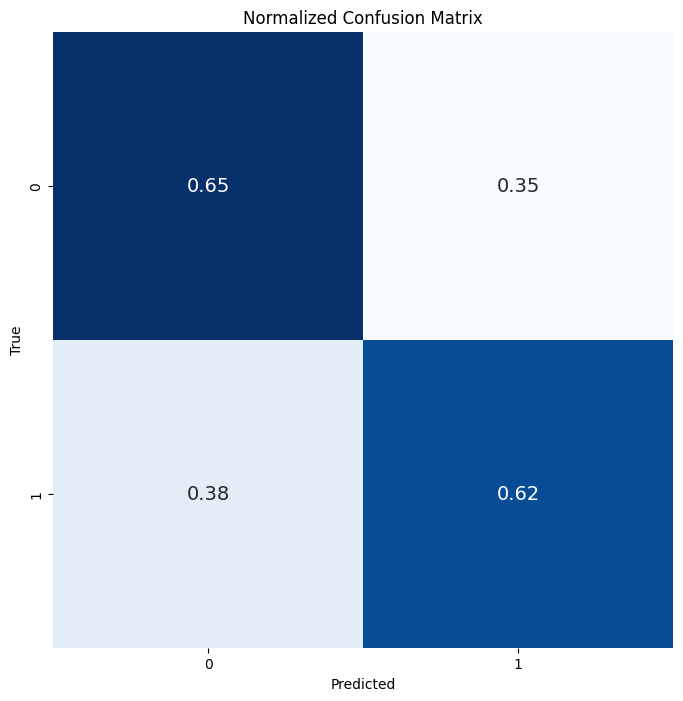

In [31]:
# @title <font color='black'><b>**Matrice de confuison sur les données de test**</b></font> { run: "auto" }
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, cmap="Blues", cbar=False, annot_kws={"size": 14})
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Utilisation de la fonction pour afficher la matrice de confusion
true_labels = merged_data['label_x']
predicted_labels = merged_data['label_y']
plot_confusion_matrix(true_labels, predicted_labels)

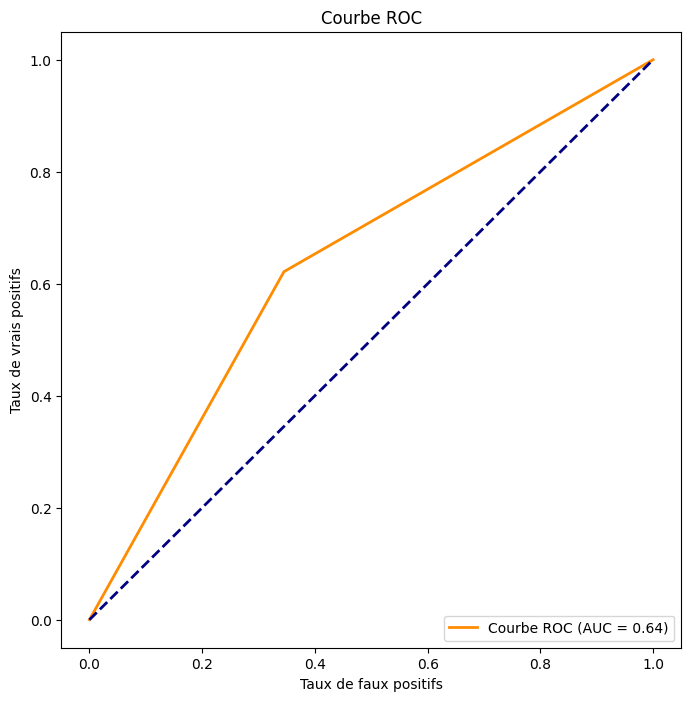

In [32]:
# @title <font color='black'><b>**Courbe de ROC sur les données de test**</b></font> { run: "auto" }
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(true_labels, predicted_labels):
    # Calculer la courbe ROC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
    roc_auc = auc(fpr, tpr)

    # Afficher la courbe ROC
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.show()
# Exemple d'utilisation
true_labels = merged_data['label_x']
predicted_labels = merged_data['label_y']
plot_roc_curve(true_labels, predicted_labels)

#<font color='blue'><b>Interface</b></font>

##<font color='blue'><b>Interface Utilisateur :</b></font>

In [ ]:
# @title <font color='black'><b>Bibliothéques :</b></font> { run: "auto" }
!pip install googletrans==4.0.0-rc1
from googletrans import Translator
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F
import ipywidgets as widgets

In [ ]:
# @title <font color='black'><b>Modéle :</b></font> { run: "auto" }
# Charger le modèle BERT pour la classification de séquence
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Charger les poids du modèle sauvegardé
model.load_state_dict(torch.load('/content/model/best_model_weights.pth'))

# Définir le dispositif d'exécution (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mettre le modèle sur le même dispositif
model.to(device)

# Mettre le modèle en mode d'évaluation
model.eval()

In [13]:
# @title <font color='black'><b>Traduction :</b></font> { run: "auto" }
# Fonction pour traduire l'article en anglais
from googletrans import Translator

def translate_to_english(article):
    translator = Translator()
    translated_article = translator.translate(article, src='fr', dest='en').text
    return translated_article

In [14]:
# @title <font color='black'><b>Eval :</b></font> { run: "auto" }
# Fonction pour évaluer la fiabilité de l'article
def evaluate_article(article, model, device):
    # Prétraiter l'article pour BERT
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    encoded_data = tokenizer.encode_plus(
        article,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        max_length=256,
        return_tensors='pt',
        truncation=True
    )

    input_ids = encoded_data['input_ids'].to(device)
    attention_mask = encoded_data['attention_mask'].to(device)

    # Évaluer l'article avec le modèle
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = F.softmax(logits, dim=1)
    probability_fiable = probabilities[:, 0].item()  # Probabilité d'être fiable (classe 0)

    # Degré de fiabilité
    degre_fiabilite = 'Élevé' if probability_fiable > 0.5 else 'Faible'

    return probability_fiable, degre_fiabilite

In [15]:
# @title <font color='black'><b>Interface :</b></font> { run: "auto" }
# Fonction pour l'interface utilisateur
def on_button_click(btn):
    article_francais = text_input.value

    # Traduction de l'article en anglais
    article_anglais = translate_to_english(article_francais)

    # Évaluation de la fiabilité de l'article
    prob_fiable, degre_fiabilite = evaluate_article(article_anglais, model, device)

    prob_fiable_percent = prob_fiable * 100
    output_text.value = f"Probabilité d'être fiable : {prob_fiable_percent:.2f}%\nDegré de fiabilité : {degre_fiabilite}"

In [16]:
# @title <font color='black'><b>Réinitialisation :</b></font> { run: "auto" }
# Fonction pour réinitialiser l'interface
import ipywidgets as widgets
def reset_interface(btn):
    text_input.value = ""  # Effacer le champ de texte
    output_text.value = ""  # Effacer les résultats d'évaluation

# Créer les widgets
text_input = widgets.Textarea(
    placeholder="Veuillez entrer votre article de presse en français",
    layout={'height': '200px', 'width': '100%'}
)
button = widgets.Button(description="Évaluer", button_style='success')
button.on_click(on_button_click)
reset_button = widgets.Button(description="Réinitialiser", button_style='danger')
reset_button.on_click(reset_interface)
output_text = widgets.Textarea(
    placeholder="Résultats de l'évaluation",
    layout={'height': '100px', 'width': '100%'}
)
# Afficher l'interface
display(widgets.VBox([text_input, button, reset_button, output_text]))